### Изменения:
#### columns_to_drop
#### columns_to_fill_with_zero
#### columns_to_fill_with_N

In [92]:
from pyspark import HiveContext, SparkContext, SparkConf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql import functions as fn
from pyspark.sql.types import StringType, FloatType
from subprocess import call
from time import sleep
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import RandomForestClassifier as RF, LogisticRegression as LR
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np
import pandas as pd
import math
%matplotlib inline

In [125]:
try:
    sc.stop()
except:
    pass

In [3]:
os.environ['PYSPARK_SUBMIT_ARGS']='''--master yarn --deploy-mode client --num-executors 128 --executor-memory 16g 
--executor-cores 1 --conf spark.yarn.executor.memoryOverhead=4096 --conf spark.yarn.queue=mvsurovikov pyspark-shell'''

In [4]:
sc = SparkContext()
hc = HiveContext(sc)

In [40]:
columns_to_encode = '''tarif_id
,suppress_flg
,limit_change_cd
,mail_stmt_send_flg
,email_stmt_send_flg
,credit_payment_protection_cd
,gender_cd
,education_level_cd
,marital_status_cd
,has_email
,ibank_register_flg
,pensioner_flg
,job_org_own_bsns_flg
,suppress_limit
,ib_status_cd
,cust_value_cd
,auth_type
,car_type_flg
,car_own_flg'''.split('\n,')
target_column = 'churned'
num_splits = 4

In [15]:
columns_to_drop = \
['own_car_manufacturing_year','churn_dt','days_to_churn','account_rk','ymd','suppress_call_flg','suppress_mail_flg','suppress_sms_flg','suppress_fax_flg',
'suppress_email_flg','suppress_mail_flg', 'suppress_fax_flg', 'suppress_email_flg', 'suppress_sms_flg', 'suppress_call_flg', 'incorrect_overdue_flg_1m'
 , 'core_recently_opened', 'dep_recently_opened', 'svn_recently_opened', 'cur_recently_opened', 'sav_recently_opened', 'leg_recently_opened'
 , 'col_recently_opened', 'dep_recently_closed','svn_recently_closed', 'cur_recently_closed', 'sav_recently_closed', 'leg_recently_closed'
 , 'col_recently_closed', 'loan_recently_opened', 'loan_recently_closed'
]

In [32]:
columns_to_fill_with_zero = ['sum_hum_wait_time_1m', 'sum_hum_talk_time_1m', 'max_hum_wait_time_1m'
 'max_hum_talk_time_1m', 'sum_moves_cnt_1', 'call_duration_1m', 'max_call_duration_1m', 'max_moves_cnt_1m'
 'trans_debit_sum_prev_m', 'trans_debit_sum_1m', 'children_cnt']
columns_to_fill_with_N = ['suppress_limit', 'job_org_own_bsns_flg']

In [35]:
df_train_0 = hc.sql('select * from user_mvsurovikov.ch_features_clean_train').repartition(250)\
.select(*[col for col in df_train_0.columns if col not in columns_to_drop])\
.fillna(0, subset = columns_to_fill_with_zero)\
.fillna('N', subset = columns_to_fill_with_N)\
.cache()
#.fillna('__missing_val__', subset = columns_to_encode)\

In [37]:
df_train_0.count()

139645686

In [36]:
df_train_0.groupBy('job_org_own_bsns_flg').agg(*[fn.count('churned'), fn.avg('churned')]).show()

+--------------------+--------------+--------------------+
|job_org_own_bsns_flg|count(churned)|        avg(churned)|
+--------------------+--------------+--------------------+
|                   Y|       9523261|0.005864482764884844|
|                   N|     130122425|0.007262045723479254|
+--------------------+--------------+--------------------+



In [38]:
features_numeric = list(set(df_train_0.columns) - set([target_column]) - set(columns_to_encode))

In [41]:
df_train_0_splits = df_train_0.randomSplit([1.0]*num_splits, 24)
for df in df_train_0_splits:
    df.cache()

In [47]:
global_avg = df_train_0.groupBy().agg(fn.avg(target_column)).collect()[0][0]

In [48]:
global_avg

0.007166737682107845

In [42]:
columns_to_encode_values = {}
for i in range(num_splits):
    columns_to_encode_values[i] = {}
    for col in columns_to_encode:
        columns_to_encode_values[i][col] = {}        
        gr = df_train_0_splits[i].groupBy(col).agg(fn.sum(target_column), fn.count(target_column)).collect()
        for x in gr:
            columns_to_encode_values[i][col][x[0]] = (x[1], x[2])

In [49]:
columns_to_encode_cds = {}
for i in range(num_splits):
    for col in columns_to_encode:
        try:
            columns_to_encode_cds[col].extend(columns_to_encode_values[i][col].keys())
        except:
            columns_to_encode_cds[col] = columns_to_encode_values[i][col].keys()

for cd in columns_to_encode_cds.keys():
    columns_to_encode_cds[cd] = list(set(columns_to_encode_cds[cd]))

In [50]:
columns_to_encode_sums = {}
for i in range(num_splits):
    columns_to_encode_sums[i] = {}
    for column in columns_to_encode:
        columns_to_encode_sums[i][column] = {}
        for cd in columns_to_encode_cds[column]:
            columns_to_encode_sums[i][column][cd] = [0, 0]

In [51]:
for i in range(num_splits): 
    for j in range(num_splits):
        if i <> j:
            for col in columns_to_encode:
                for cd in columns_to_encode_cds[col]:
                    try:
                        columns_to_encode_sums[i][col][cd][0] += columns_to_encode_values[j][col][cd][0]
                        columns_to_encode_sums[i][col][cd][1] += columns_to_encode_values[j][col][cd][1]
                    except:
                        pass                    

In [95]:
columns_to_encode_encoded = {}
for i in range(num_splits):
    columns_to_encode_encoded[i] = {}
    for column in columns_to_encode:
        columns_to_encode_encoded[i][column] = {}
        for cd in columns_to_encode_cds[column]:
            if cd is not None:
                columns_to_encode_encoded[i][column][cd] = (1.0*columns_to_encode_sums[i][column][cd][0] + 100.0*global_avg)/(1.0*columns_to_encode_sums[i][column][cd][1]+100)                
            else:
                columns_to_encode_encoded[i][column][cd] = global_avg

In [97]:
def label_encode(i, c, c_val):
    try:
        res = columns_to_encode_encoded[i][c][c_val]
    except:
        res = global_avg
    return res

In [98]:
def mapper(row):
    data = row.asDict()
    for c in columns_to_encode:
        data[c + '_encoded'] = label_encode(i, c, data[c])
    return Row(**data)

In [99]:
rdd_train_l = []
for i in range(num_splits):
    rdd_tmp = df_train_0_splits[i].rdd
    rdd_tmp = rdd_tmp.map(lambda x: mapper(x))
    rdd_train_l.append(rdd_tmp)

In [100]:
features_encoded = [name + '_encoded' for name in columns_to_encode]
features_all = features_encoded + features_numeric
label_features_all = [target_column] + features_all

In [101]:
df_train_1 = sc.union(rdd_train_l).toDF(sampleRatio=0.05).select([c for c in label_features_all])

In [102]:
def vectorizeData(df):
    return df.rdd.map(lambda x: [x[0], Vectors.dense(x[1:])]).toDF(['label','features'])

In [103]:
vectorized_train_data = vectorizeData(df_train_1)

In [104]:
vectorized_train_data.take(1)

[Row(label=0, features=DenseVector([0.0072, 0.0072, 0.0072, 0.0072, 0.0072, 0.0072, 0.0068, 0.0071, 0.007, 0.0073, 0.0072, 0.0072, 0.0073, 0.0071, 0.0073, 0.0072, 0.0069, 0.0067, 0.0069, 0.0, 0.0, 0.0, 0.0, 2.4769, 0.0, 1.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, 0.0, 0.0, 0.0, nan, nan, 0.0, 0.0, 0.0, 3000.0, nan, 1.0, 0.0, 1.0, nan, 0.0, 1.0, 0.0, nan, 0.0, 20523.7625, 0.0, 1.0, 0.0, 3000.0, 0.0, 0.0, 3.0, 0.0, 0.0, 1.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, 1.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 1390.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, nan, 0.0, 20523.7619, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 36.4384, 0.0, nan, 0.0, 0.0]))]

In [105]:
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(vectorized_train_data)

In [107]:
trainingData = vectorized_train_data
trainingData.cache()
numFolds = 5

rf_cv = RF(labelCol="indexedLabel", featuresCol="features")
evaluator = BinaryClassificationEvaluator(labelCol="indexedLabel")

pipeline = Pipeline(stages=[labelIndexer, rf_cv])

paramGrid = ParamGridBuilder().addGrid(rf_cv.maxDepth, [5]).addGrid(rf_cv.numTrees, [100]).build()
#paramGrid = ParamGridBuilder().addGrid(rf_cv.maxDepth, [2,3]).addGrid(rf_cv.numTrees, [5,10]).build()

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

model = crossval.fit(trainingData)

In [108]:
print model.avgMetrics
print model.bestModel

[0.7008682883640599]
PipelineModel_4b6ca991fa2b2d4cc97a


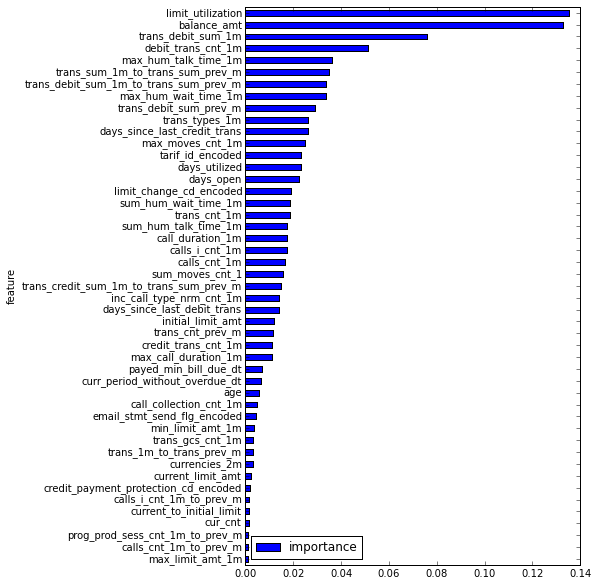

In [109]:
imp = np.array(model.bestModel.stages[1].featureImportances, dtype=np.float64)

feature_importance = zip(features_all, imp)
    
feature_importance = sorted(feature_importance, key=lambda tup: tup[1])
df = pd.DataFrame(feature_importance, columns=['feature', 'importance'])
df = df[df['importance'] > 0.001]
df.plot(kind='barh', x='feature', y='importance', figsize=(6, 10))

In [110]:
df_test_0 = hc.sql('select * from user_mvsurovikov.ch_features_clean_test').repartition(250)\
.select(*[col for col in df_train_0.columns if col not in columns_to_drop])\
.fillna(0, subset = columns_to_fill_with_zero)\
.fillna('N', subset = columns_to_fill_with_N)\
.cache()
#.fillna('__missing_val__', subset = columns_to_encode)\

In [124]:
global_avg

0.007166737682107845

In [123]:
df_test_0.agg(fn.avg('churned')).show()

+--------------------+
|        avg(churned)|
+--------------------+
|0.006410825632370339|
+--------------------+



In [111]:
rdd_tmp = df_test_0.rdd.map(lambda x: mapper(x))

In [112]:
rdd_tmp.count()

19684984

In [113]:
df_test_1 = rdd_tmp.toDF(sampleRatio=0.05).select([c for c in label_features_all])

def vectorizeData(df):
    return df.rdd.map(lambda x: [x[0], Vectors.dense(x[1:])]).toDF(['label','features'])

vectorized_test_data = vectorizeData(df_test_1)

In [114]:
transformed_test = model.transform(vectorized_test_data)

In [115]:
evaluator.evaluate(transformed_test)

0.7640289678318556

In [116]:
transformed_train = model.transform(vectorized_train_data)
evaluator.evaluate(transformed_train)

0.7017519269346445